In [14]:
import os
os.environ['THEANO_FLAGS']='device=cpu,floatX=float64'

import pymc3  as pm
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import pickle 
import time
import watermark

from gr4j_theano import gr4j_transform, static_gr4j_pm_model, model_wrapper
from gr4j_theano import (constant_prior,
    changepoint_prior,
    grw_prior,
    linear_basis_prior,
    sparse_matern_gp_prior,
    )

from itertools import product
from functools import partial

np.random.seed(827)

input_filepath         = 'data/strawberry_river_arkansas_07074000.csv'
static_params_filepath = 'data/gr4j_static_params.pkl'
synth_streamflow_path  = 'data/synthetic_streamflow.pkl'
run_static_model       = False
generate_synthetic     = True
log_filepath           = 'log.txt'

np.set_printoptions(formatter={'float': '{: 0.2f}'.format})



In [4]:
%matplotlib inline
%load_ext watermark
%watermark -iv


matplotlib: 3.4.2
arviz     : 0.11.0
pymc3     : 3.9.3
numpy     : 1.19.5
theano    : 1.0.4
watermark : 2.2.0
pandas    : 1.3.0



In [15]:
T        = 300
start    = 15115
input_df = pd.read_csv(input_filepath)
data     = input_df.iloc[start:start+T]
times    = pd.DatetimeIndex(data['year'].astype(str) + '-' + data['month'].astype(str)+ '-' + data['day'].astype(str))


In [18]:
data[['p','q','pet']].mean() * 365

p      2387.185167
q      1395.323582
pet    1028.247583
dtype: float64

In [20]:
input_df[['q', 'p', 'pet']].max()

q      108.2303
p      223.7000
pet      5.0960
dtype: float64

In [22]:
data[['q', 'p', 'pet']].min()

q      0.3775
p      0.0000
pet    0.7900
dtype: float64

### Estimating static parameters for GR4J

In [5]:
if run_static_model:
    static_model, static_varnames = static_gr4j_pm_model(data['p'].values, data['pet'].values, data['q'].values)
    with static_model:
        step = pm.Metropolis()
        trace = pm.sample(step=step, tune=500, draws=2000)

    static_posterior_estimate = {x: trace[x].mean(axis=0, keepdims=True) for x in static_varnames}
    with open(static_params_filepath, 'wb') as dst:
        pickle.dump(static_posterior_estimate, dst)
        
else:
    with open(static_params_filepath, 'rb') as src:
        static_posterior_estimate = pickle.load(src)
static_posterior_estimate

{'theta': array([[ 329.56,  0.12,  15.14,  2.12]]),
 'S0': array([ 247.54]),
 'R0': array([ 7.44]),
 'error_sigma': array([ 2.68])}

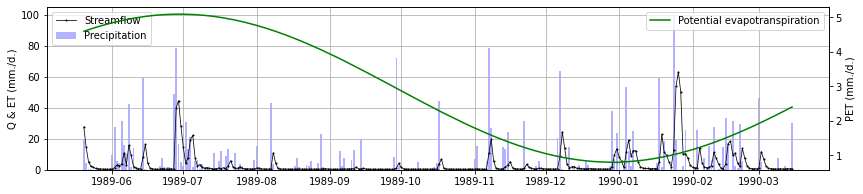

In [6]:
plt.figure(figsize=(14,3))
ax = plt.plot(times,data['q'].values, color='k',linewidth=0.75, marker='o',
              markersize=1, label='Streamflow')
plt.bar(times,height=data['p'].values, color='b',alpha=0.3, label='Precipitation')
plt.ylabel('Q & ET (mm./d.)')
plt.legend(loc='upper left')
plt.grid('on')
twinx = plt.gca().twinx()
twinx.plot(times,data['pet'].values, color='g', label='Potential evapotranspiration')
twinx.set_ylabel('PET (mm./d.)')
twinx.legend();


### Creating synthetic data

In [7]:
def kernel_function(x, l=1):
    '''
    Gaussian kernel function parameterized by
    lengthscale `l`.
    '''
    pairwise_distance = x[:, None] - x[None, :]
    return np.exp(-(pairwise_distance**2)/(2*l**2))

if generate_synthetic:
    synthetic_streamflow = {}
    nugget   = 1E-6
    K        = kernel_function(np.arange(T), l=80) + np.eye(T) * nugget
    L        = np.linalg.cholesky(K)
    midpoint = int(T/2)
    
    tvp_true = {
        'Constant'    : np.ones(T)*500,
        'Change-point': np.concatenate([np.ones(midpoint)*400, np.ones(midpoint)*650]),
        'Random walk' : np.cumsum(np.random.randn(T)*10) + 600,
        'Linear basis': 500 + np.linspace(-1,1,T) * 250 + np.sin(np.linspace(0,4*np.pi,T)) * 50,
        'GP'          :  L @ np.random.randn(T)*150 + 600
                }
    
    lower    = 600 # Bounds for the first GR4J parameter
    upper    = 601
    err_sd   = 0.5
    x4_limit = 5

    basis_functions = np.stack([30*np.linspace(0,1,T), 5*np.sin(4*np.pi*np.linspace(0,1,T))], axis=1)
    basis_functions *= (upper-lower)*0.2

    theta = static_posterior_estimate['theta'].squeeze()
    
    # Shape is (T,1) to match signature of raw streamflow, to which
    # this variable is later added.
    noise_variates = np.random.randn(T,1) * err_sd

    for name, f in tvp_true.items():

        S0 = np.asarray(static_posterior_estimate['S0'][0], dtype='float64')
        R0 = np.asarray(static_posterior_estimate['R0'], dtype='float64')
        with pm.Model() as model:
            tvp = pm.math.constant(f) 
            raw_streamflow = gr4j_transform(tvp,
                           theta[1],
                           theta[2],
                           theta[3],
                           x4_limit,
                           S0,R0, 
                           data['p'].iloc[0:T].values, 
                           data['pet'].iloc[0:T].values)
            raw_streamflow = pm.Deterministic('raw_streamflow', raw_streamflow)
            streamflow     = pm.Deterministic('streamflow', raw_streamflow+noise_variates)

            if name in tvp_true.keys():
                theta_1 = pm.Deterministic('theta_1', tvp.squeeze())
                
            synthetic_streamflow[name] = pm.sample_prior_predictive(samples=1)
            synthetic_streamflow[name]['p']  = data['p'].iloc[0:T].values
            synthetic_streamflow[name]['pet']= data['pet'].iloc[0:T].values

            print(name, synthetic_streamflow[name]['theta_1'].shape,synthetic_streamflow[name]['streamflow'].shape)

    with open(synth_streamflow_path, 'wb') as dst:
        pickle.dump(synthetic_streamflow, dst)
            
else: 
    with open(synth_streamflow_path, 'rb') as src:
        synthetic_streamflow = pickle.load(src)
    
            

Constant (300,) (300, 1)
Change-point (300,) (300, 1)
Random walk (300,) (300, 1)
Linear basis (300,) (300, 1)
GP (300,) (300, 1)


### Visualizing true TVPs

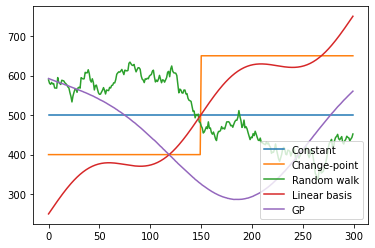

In [8]:
for name, synth in synthetic_streamflow.items():
    samples = synthetic_streamflow[name]
    plt.plot(samples['theta_1'].squeeze(), label=name)
    plt.legend(loc='lower right')


### Estimating TVPs

In [9]:
tvp_inference_models = {
    'Constant'    : constant_prior,
    'Change-point': partial(changepoint_prior),
    'Random walk' : partial(grw_prior, resolution=5, prefix_zero=True),
    'Linear basis': partial(linear_basis_prior, basis_functions=basis_functions),
    'GP'          : partial(sparse_matern_gp_prior, resolution=5),
}

scenarios = list(product(tvp_inference_models.keys(), tvp_inference_models.keys()))

name_to_kwargs = {
    'Change-point':{
        'step'  : 'metropolis',
        'tune'  : 20000,
        'draws' : 10000,
        'chains': 2,
        'cores' : 4,
    },
    'Constant':{
        'step'  : 'metropolis',
        'tune'  : 20000,
        'draws' : 10000,
        'chains': 2,
        'cores' : 4,  
    },
    
}
for name in ['Linear basis']:
    name_to_kwargs[name] = {
        'step' : 'nuts',
        'tune' : 2000,
        'draws': 1000,
        'cores': 4,
        'chains':2,
        'target_accept':0.80
    }

for name in ['Random walk', 'GP']:
    name_to_kwargs[name] = {
        'step'  : 'nuts',
        'tune'  : 2000,
        'draws' : 1000,
        'cores' : 4,
        'chains': 2,
        'target_accept':0.80
    }

input_tuples = [
    (data, synthetic_streamflow[true]['streamflow'].squeeze(), tvp_inference_models[assumed],f'{true}_{assumed}', name_to_kwargs[assumed])
    for true, assumed in scenarios
]

### Forward iteration

In [27]:
times  = []
traces = []
start  = time.time()
for t in input_tuples:
    print(f'Starting computation for {t[3]}')
    filepath = save_dir + t[3] + '.pkl'
    if not os.path.exists(filepath):
        try:
            save_dir='./traces/run_9_7/'
            model  = model_wrapper(t, return_model=True)

            with model:
                trace = pm.sample(tune=2500, draws=1000, chains=4, cores=4)

            traces += [trace]
            times  += [time.time() - start]

            with open(filepath, 'wb') as dst:
                pickle.dump(trace, dst)
            with open(log_filepath, 'w') as dst:
                dst.write(f'Sampling for {t[3]} complete in {times[-1]} seconds.')
                
        except RuntimeError:
            print(f'Runtime error (likely numerical issues) occured for {t[3]}')

Starting computation for Constant_Constant
Starting computation for Constant_Change-point
Starting computation for Constant_Random walk
Starting computation for Constant_Linear basis
Starting computation for Constant_GP
Starting computation for Change-point_Constant
Starting computation for Change-point_Change-point
Starting computation for Change-point_Random walk
Starting computation for Change-point_Linear basis
Starting computation for Change-point_GP
Starting computation for Random walk_Constant


WARNING (theano.gof.compilelock): Overriding existing lock by dead process '90311' (I am process '67585')
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [R0_fraction, S0_fraction, intercept, err_sd, theta_static]
INFO:pymc3:NUTS: [R0_fraction, S0_fraction, intercept, err_sd, theta_static]


INFO (theano.gof.compilelock): Waiting for existing lock by process '90474' (I am process '90498')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/v7k/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.8.10-64/lock_dir
Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 687 seconds.
INFO:pymc3:Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 687 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


Starting computation for Random walk_Change-point


Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>NUTS: [R0_fraction, S0_fraction, period_values, err_sd, theta_static]
INFO:pymc3:>NUTS: [R0_fraction, S0_fraction, period_values, err_sd, theta_static]
>Metropolis: [changepoint]
INFO:pymc3:>Metropolis: [changepoint]


INFO (theano.gof.compilelock): Waiting for existing lock by process '91132' (I am process '91108')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/v7k/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.8.10-64/lock_dir
Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 969 seconds.
INFO:pymc3:Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 969 seconds.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


Starting computation for Random walk_Random walk


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [R0_fraction, S0_fraction, delta, sigma_delta, intercept, err_sd, theta_static]
INFO:pymc3:NUTS: [R0_fraction, S0_fraction, delta, sigma_delta, intercept, err_sd, theta_static]


INFO (theano.gof.compilelock): Waiting for existing lock by process '92061' (I am process '92039')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/v7k/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.8.10-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '92061' (I am process '92110')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/v7k/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.8.10-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '92039' (I am process '92110')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/v7k/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.8.10-64/lock_dir
Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 10448 seconds.
INFO:pymc3:Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 10448 seconds.
There were 4 d

Starting computation for Random walk_Linear basis


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [R0_fraction, S0_fraction, beta, beta_sigma, intercept, err_sd, theta_static]
INFO:pymc3:NUTS: [R0_fraction, S0_fraction, beta, beta_sigma, intercept, err_sd, theta_static]


INFO (theano.gof.compilelock): Waiting for existing lock by process '1532' (I am process '1484')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/v7k/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.8.10-64/lock_dir
Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 1730 seconds.
INFO:pymc3:Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 1730 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


Starting computation for Random walk_GP


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
/Users/v7k/anaconda3/envs/gr4j-env/lib/python3.8/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [R0_fraction, S0_fraction, low_resolution, intercept, gp_scale, rho, err_sd, theta_static]
INFO:pymc3:NUTS: [R0_fraction, S0_fraction, low_resolution, intercept, gp_scale, rho, err_sd, theta_static]


INFO (theano.gof.compilelock): Waiting for existing lock by process '2842' (I am process '2864')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/v7k/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.8.10-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '2888' (I am process '2913')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/v7k/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.8.10-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '2888' (I am process '2864')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/v7k/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.8.10-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '2888' (I am process '2913')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/v7k/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.8.10-64/lock_

Starting computation for Linear basis_Constant


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [R0_fraction, S0_fraction, intercept, err_sd, theta_static]
INFO:pymc3:NUTS: [R0_fraction, S0_fraction, intercept, err_sd, theta_static]


INFO (theano.gof.compilelock): Waiting for existing lock by process '59304' (I am process '59257')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/v7k/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.8.10-64/lock_dir
Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 670 seconds.
INFO:pymc3:Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 670 seconds.


Starting computation for Linear basis_Change-point


Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>NUTS: [R0_fraction, S0_fraction, period_values, err_sd, theta_static]
INFO:pymc3:>NUTS: [R0_fraction, S0_fraction, period_values, err_sd, theta_static]
>Metropolis: [changepoint]
INFO:pymc3:>Metropolis: [changepoint]


Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 829 seconds.
INFO:pymc3:Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 829 seconds.
The number of effective samples is smaller than 10% for some parameters.


Starting computation for Linear basis_Random walk


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [R0_fraction, S0_fraction, delta, sigma_delta, intercept, err_sd, theta_static]
INFO:pymc3:NUTS: [R0_fraction, S0_fraction, delta, sigma_delta, intercept, err_sd, theta_static]


INFO (theano.gof.compilelock): Waiting for existing lock by process '60582' (I am process '60603')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/v7k/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.8.10-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '60582' (I am process '60632')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/v7k/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.8.10-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '60603' (I am process '60632')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/v7k/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.8.10-64/lock_dir
Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 2200 seconds.
INFO:pymc3:Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 2200 seconds.
There were 27 di

Starting computation for Linear basis_Linear basis


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [R0_fraction, S0_fraction, beta, beta_sigma, intercept, err_sd, theta_static]
INFO:pymc3:NUTS: [R0_fraction, S0_fraction, beta, beta_sigma, intercept, err_sd, theta_static]


INFO (theano.gof.compilelock): Waiting for existing lock by process '62603' (I am process '62549')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/v7k/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.8.10-64/lock_dir
Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 1337 seconds.
INFO:pymc3:Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 1337 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 5 divergences after tuning. Increase `target_accept` or repara

Starting computation for Linear basis_GP


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
/Users/v7k/anaconda3/envs/gr4j-env/lib/python3.8/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [R0_fraction, S0_fraction, low_resolution, intercept, gp_scale, rho, err_sd, theta_static]
INFO:pymc3:NUTS: [R0_fraction, S0_fraction, low_resolution, intercept, gp_scale, rho, err_sd, theta_static]


INFO (theano.gof.compilelock): Waiting for existing lock by process '63790' (I am process '63768')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/v7k/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.8.10-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '63746' (I am process '63822')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/v7k/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.8.10-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '63746' (I am process '63768')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/v7k/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.8.10-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '63822' (I am process '63768')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/v7k/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.8.10-

Starting computation for GP_Constant


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [R0_fraction, S0_fraction, intercept, err_sd, theta_static]
INFO:pymc3:NUTS: [R0_fraction, S0_fraction, intercept, err_sd, theta_static]


INFO (theano.gof.compilelock): Waiting for existing lock by process '34421' (I am process '34448')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/v7k/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.8.10-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '34421' (I am process '34475')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/v7k/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.8.10-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '34448' (I am process '34475')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/v7k/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.8.10-64/lock_dir
Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 660 seconds.
INFO:pymc3:Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 660 seconds.
There was 1 diverg

Starting computation for GP_Change-point


Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>NUTS: [R0_fraction, S0_fraction, period_values, err_sd, theta_static]
INFO:pymc3:>NUTS: [R0_fraction, S0_fraction, period_values, err_sd, theta_static]
>Metropolis: [changepoint]
INFO:pymc3:>Metropolis: [changepoint]


INFO (theano.gof.compilelock): Waiting for existing lock by process '35189' (I am process '35117')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/v7k/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.8.10-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '35141' (I am process '35117')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/v7k/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.8.10-64/lock_dir
Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 797 seconds.
INFO:pymc3:Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 797 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:p

Starting computation for GP_Random walk


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [R0_fraction, S0_fraction, delta, sigma_delta, intercept, err_sd, theta_static]
INFO:pymc3:NUTS: [R0_fraction, S0_fraction, delta, sigma_delta, intercept, err_sd, theta_static]


INFO (theano.gof.compilelock): Waiting for existing lock by process '35937' (I am process '35882')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/v7k/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.8.10-64/lock_dir
Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 3865 seconds.
INFO:pymc3:Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 3865 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 11 divergences after tuning. Increase `target_accept` or reparamete

Starting computation for GP_Linear basis


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [R0_fraction, S0_fraction, beta, beta_sigma, intercept, err_sd, theta_static]
INFO:pymc3:NUTS: [R0_fraction, S0_fraction, beta, beta_sigma, intercept, err_sd, theta_static]


Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 1177 seconds.
INFO:pymc3:Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 1177 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Starting computation for GP_GP


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
/Users/v7k/anaconda3/envs/gr4j-env/lib/python3.8/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [R0_fraction, S0_fraction, low_resolution, intercept, gp_scale, rho, err_sd, theta_static]
INFO:pymc3:NUTS: [R0_fraction, S0_fraction, low_resolution, intercept, gp_scale, rho, err_sd, theta_static]


INFO (theano.gof.compilelock): Waiting for existing lock by process '39846' (I am process '39824')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/v7k/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.8.10-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '39846' (I am process '39800')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/v7k/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.8.10-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '39800' (I am process '39883')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/v7k/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.8.10-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '39824' (I am process '39883')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/v7k/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.8.10-